<a href="https://colab.research.google.com/github/alexchan7/EKPA/blob/main/Network%20Traffic%20Anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries
!pip install pandas scikit-learn matplotlib seaborn


In [35]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder
import socket
import struct

In [36]:
# Function to convert IP addresses to integers
def ip_to_int(ip):
    return struct.unpack("!I", socket.inet_aton(ip))[0]

In [37]:
# Load the dataset
url = "https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/network_traffic_data.csv"
data = pd.read_csv(url)

In [38]:
# Display the first few rows and the column names of the dataset
print(data.head())
print(data.columns)

           src_ip         dest_ip  src_port  dest_port protocol  packet_size  \
0    114.208.13.8  122.46.117.227     57422      33910     ICMP     1.646143   
1   39.193.236.24    38.15.247.21     33946      34501      UDP     0.871719   
2  102.200.245.21  212.53.148.199     41742      49649      TCP     0.554511   
3   234.237.3.153   240.15.58.246     49115      53733     ICMP     0.652771   
4   185.28.108.97   30.169.201.31     18404      29740      UDP     1.592741   

   num_packets  flow_duration  bytes_transferred  packet_rate  \
0           29             23              27562         1887   
1           36             51              25373         1723   
2           42             59              47105         1099   
3           26             70              31164         1948   
4           20             13               2885         1661   

             timestamp  
0  2023-01-01 00:00:00  
1  2023-01-01 00:01:00  
2  2023-01-01 00:02:00  
3  2023-01-01 00:03:00  
4  

In [39]:
# Preprocess the data
# Drop rows with missing values for simplicity
data = data.dropna()

In [40]:
ip_columns = ['src_ip', 'dest_ip']  # Replace with actual IP address columns
for col in ip_columns:
    data[col] = data[col].apply(ip_to_int)

In [43]:
# Encode categorical columns like 'Protocol'
categorical_columns = ['protocol']  # Replace with actual categorical column names
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [46]:
# Convert timestamp to datetime and extract features
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['hour'] = data['timestamp'].dt.hour
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data = data.drop(columns=['timestamp'])

In [47]:
# Extract features
X = data.values

In [48]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [49]:
# Train the Isolation Forest model
model = IsolationForest(contamination=0.1, random_state=42)  # assuming 10% contamination
model.fit(X_scaled)

IsolationForest(contamination=0.1, random_state=42)

In [50]:
# Predict anomalies
y_pred = model.predict(X_scaled)

In [51]:
# IsolationForest outputs -1 for anomalies and 1 for normal instances
anomalies = np.where(y_pred == -1, 1, 0)  # Convert to binary output where 1 is anomaly

In [52]:
# Add predictions to the original data for visualization
data['Anomaly'] = anomalies

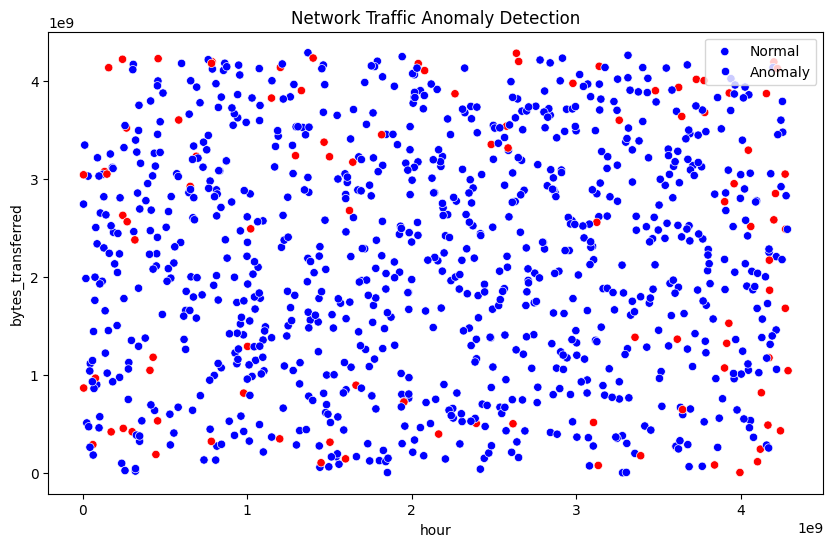

In [62]:
# Visualize the results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x=data.columns[0], y=data.columns[1], hue='Anomaly', palette=['blue', 'red'])
plt.title('Network Traffic Anomaly Detection')
plt.xlabel(data.columns[10])
plt.ylabel(data.columns[8])
plt.legend(['Normal', 'Anomaly'])
plt.show()

In [54]:
# Calculate and print entropy of the anomaly predictions
from scipy.stats import entropy

In [55]:
# Calculate the probability distribution of anomalies
anomaly_counts = np.bincount(anomalies)
anomaly_probs = anomaly_counts / len(anomalies)

In [56]:
# Calculate entropy
anomaly_entropy = entropy(anomaly_probs)
print(f'Entropy of the anomaly predictions: {anomaly_entropy:.4f}')

Entropy of the anomaly predictions: 0.3251
